# **Project Notebook**

This notebook contains the code work for Data Science project "Uncertainty quantification of deep neural networks for high-dimensional data" for the CS-E4875 course.

In [1]:
# imports
import pandas as pd
import dask.dataframe as dd
import dask
import pyarrow.parquet as pq

from functools import partial
from itertools import chain

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import joblib



/opt/software/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [2]:
from datetime import date

today = date.today()

save_date = today.strftime("%d_%m_%Y")
print("run_date: ", save_date)

run_date:  24_06_2024


In [3]:
# CONSTANTS
MODEL_SAVE_PATH = "./saved_models/" 
TRAINING_DATA_SAVE_PATH = "./saved_training_data/"

Add overwrite condition that will overwrite the replication data with the most recent one

In [4]:
OVERWRITE = True

## Helper scripts

In [5]:
# save the model to avoid need to rerun training every time

def handle_model(model_name, model, X, y, learner, epochs, overwrite_model=False):
    full_model_path = MODEL_SAVE_PATH + model_name + f"_{epochs}.pth"
    if os.path.exists(full_model_path) and overwrite_model is False:
        print("Model exists, loading...")
        model.load_state_dict(torch.load(full_model_path))
        model.eval()
        print("== Model loaded! == ")
    else:
        print("Model not found or overwrite_model=True: training and saving new model...")
        learner.fit(X, y, epochs, batch_size=10)
        torch.save(model.state_dict(), full_model_path)
        print("== Model saved! == ")

In [6]:
# save training data to ensure replicability

def handle_training_data(training_data_name):
    data_path = TRAINING_DATA_SAVE_PATH + training_data_name + ".csv"
    if os.path.exists(data_path):
        print("Training data exists, loading...")
        data = pd.read_csv(data_path)
        print("== Training data fetched == ")
        return data
    else:
        print(f"No training data available in location {data_path}. Please create one")
        return None

## Evaluation function

In [7]:
def calculate_picp(actual_values, lower_bounds, upper_bounds):
    coverage = np.sum((actual_values >= lower_bounds) & (actual_values <= upper_bounds))
    picp = coverage / len(actual_values)
    return picp

def calculate_pinaw(actual_values, lower_bounds, upper_bounds):
    interval_widths = upper_bounds - lower_bounds
    data_range = np.max(actual_values) - np.min(actual_values)
    normalized_widths = interval_widths / data_range
    pinaw = np.mean(normalized_widths)
    return pinaw

def calculate_cwc(actual_values, lower_bounds, upper_bounds, alpha=0.9):
    mu = 1 - alpha  # Define mu as 1 - alpha
    eta = 50  # Define eta as 50, a hyperparameter

    picp = calculate_picp(actual_values, lower_bounds, upper_bounds)
    pinaw = calculate_pinaw(actual_values, lower_bounds, upper_bounds)
    
    # Calculate gamma(PICP) based on the condition
    if picp < mu:
        gamma_picp = 1
    else:
        gamma_picp = 0
    
    cwc = pinaw * (1 + gamma_picp * (np.exp(mu**eta - picp**eta)))

    return cwc

## Model with mock data
I'll re-implement the model below, using the version from https://blog.ceshine.net/post/quantile-regression-part-2/#source-code

In [8]:
np.random.seed(100)

# ## Prepare Dataset

def f(x):
    """The function to predict."""
    return x * np.sin(x)

#----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Observations
y = f(X).ravel()

dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Calculate bounds
n_std = 1.645  # For approximately 90% coverage
upper_bound = f(X).ravel() + n_std * dy
lower_bound = f(X).ravel() - n_std * dy

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

X.shape, y.shape, xx.shape

((100, 1), (100,), (1000, 1))

In [9]:
class q_model(nn.Module):
    def __init__(self, 
                 quantiles, 
                 in_shape=1,  
                 dropout=0.5):     
        super().__init__()
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = len(quantiles)
        self.dropout = dropout
        self.build_model()
        self.init_weights()
        
    def build_model(self): 
        self.base_model = nn.Sequential(
            nn.Linear(self.in_shape, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
            nn.Linear(64, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
        )
        final_layers = [
            nn.Linear(64, 1) for _ in range(len(self.quantiles))
        ]
        self.final_layers = nn.ModuleList(final_layers)
        
    def init_weights(self):
        for m in chain(self.base_model, self.final_layers):
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight)
                nn.init.constant_(m.bias, 0)        
        
    def forward(self, x):
        tmp_ = self.base_model(x)
        return torch.cat([layer(tmp_) for layer in self.final_layers], dim=1)


class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(quantiles):
            errors = target - preds[:, i]
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss


class Learner:
    def __init__(self, model, optimizer_class, loss_func, device='cpu'):
        self.model = model.to(device)
        self.optimizer = optimizer_class(self.model.parameters())
        self.loss_func = loss_func.to(device)
        self.device = device
        self.loss_history = []
        
    def fit(self, x, y, epochs, batch_size):
        self.model.train()
        for e in range(epochs):
            shuffle_idx = np.arange(x.shape[0])
            np.random.shuffle(shuffle_idx)
            x = x[shuffle_idx]
            y = y[shuffle_idx]
            epoch_losses = []
            for idx in range(0, x.shape[0], batch_size):
                self.optimizer.zero_grad()
                batch_x = torch.from_numpy(
                    x[idx : min(idx + batch_size, x.shape[0]),:]
                ).float().to(self.device).requires_grad_(False)
                batch_y = torch.from_numpy(
                    y[idx : min(idx + batch_size, y.shape[0])]
                ).float().to(self.device).requires_grad_(False)
                preds = self.model(batch_x)
                loss = loss_func(preds, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.cpu().detach().numpy())                                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if (e+1) % 500 == 0:
                print("Epoch {}: {}".format(e+1, epoch_loss))
                
    def predict(self, x, mc=False):
        if mc:
            self.model.train()
        else:
            self.model.eval()
        return self.model(torch.from_numpy(x).to(self.device).requires_grad_(False)).cpu().detach().numpy()

In [10]:
# Instantiate model
quantiles = [.05, .5, .95]
model = q_model(quantiles, dropout=0.1)
loss_func = QuantileLoss(quantiles)
learner = Learner(model, partial(torch.optim.Adam, weight_decay=1e-6), loss_func)


## Train the Model

# Run training
epochs = 10000

In [11]:
model_name = "one_dimensional_input_model"

handle_model(model_name, model, X, y, learner, epochs)
# Save data for replicability
if OVERWRITE == True:
    print("Overwriting saved training data...")
    np.save("./saved_training_data/one_dimensional_mocked_X.npy", X)
    np.save("./saved_training_data/one_dimensional_mocked_y.npy", y)

Model exists, loading...
== Model loaded! == 
Overwriting saved training data...


## PLOT MODEL OUTPUTS

In [12]:
# Make the prediction on the meshed x-axis
predicted_percentiles = learner.predict(xx) # Assuming this gives [lower, median, upper]
y_lower_pred, y_pred, y_upper_pred = predicted_percentiles[:, 0], predicted_percentiles[:, 1], predicted_percentiles[:, 2]

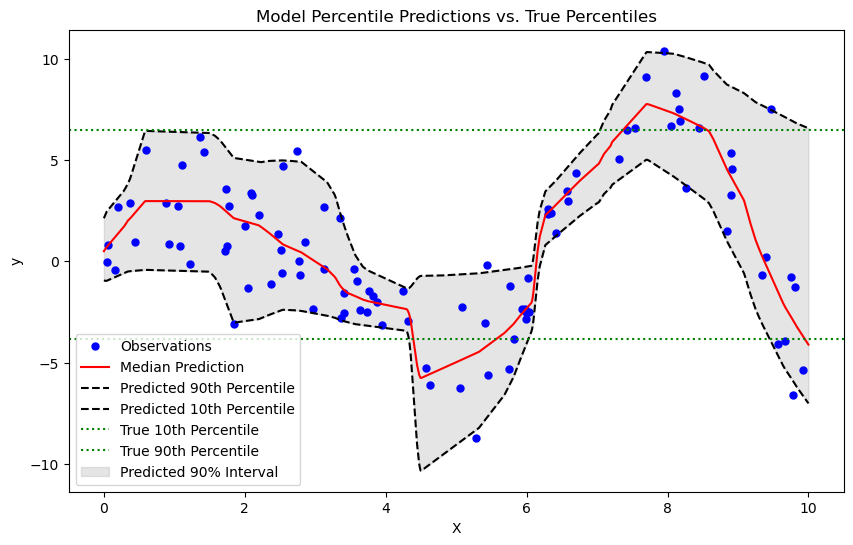

<Figure size 640x480 with 0 Axes>

In [13]:
# Plot the function, the prediction and the 90% confidence interval based on
# the MSE

# True Percentiles
y_lower_true = np.percentile(y, 10)
y_upper_true = np.percentile(y, 90)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X, y, 'b.', markersize=10, label='Observations')
plt.plot(xx, y_pred, 'r-', label='Median Prediction')
plt.plot(xx, y_upper_pred, 'k--', label='Predicted 90th Percentile')
plt.plot(xx, y_lower_pred, 'k--', label='Predicted 10th Percentile')
plt.axhline(y=y_lower_true, color='g', linestyle=':', label='True 10th Percentile')
plt.axhline(y=y_upper_true, color='g', linestyle=':', label='True 90th Percentile')
plt.fill_between(xx.ravel(), y_lower_pred, y_upper_pred, alpha=0.2, color='gray', label='Predicted 90% Interval')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Model Percentile Predictions vs. True Percentiles')
plt.legend()
plt.show()
plt.savefig('./images/prediction_dummy_data.png')
plt.show()

Percentage in the range (expecting 90%): 92.0
Percentage out of the range (expecting 10%): 8.0


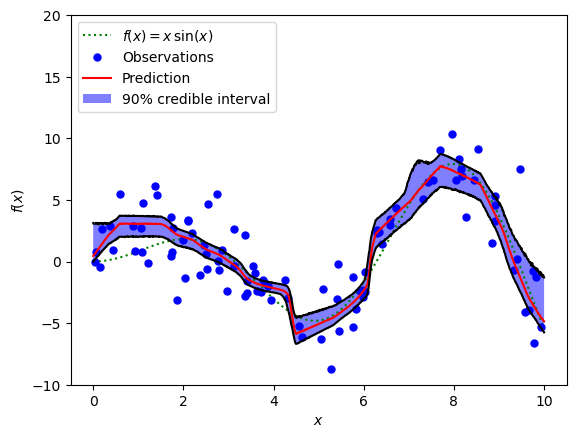

In [14]:
predictions = learner.predict(X)
np.mean(predictions[:, 0]), np.mean(predictions[:, 1]), np.mean(predictions[:, 2])


in_the_range = np.sum((y >= predictions[:, 0]) & (y <= predictions[:, 2]))
print("Percentage in the range (expecting 90%):", in_the_range / len(y) * 100)

out_of_the_range = np.sum((y < predictions[:, 0]) | (y > predictions[:, 2]))
print("Percentage out of the range (expecting 10%):", out_of_the_range / len(y)  * 100)


# ## MC Prediction

K = 5000
tmp = np.zeros((K, xx.shape[0])).astype("float32")
for k in range(K):
    preds = learner.predict(xx, mc=True)
    tmp[k] = preds[:, 1]
y_lower, y_pred, y_upper = np.percentile(tmp, (5, 50, 95), axis=0)    

y_lower[1], y_pred[1], y_upper[1]


# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% credible interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

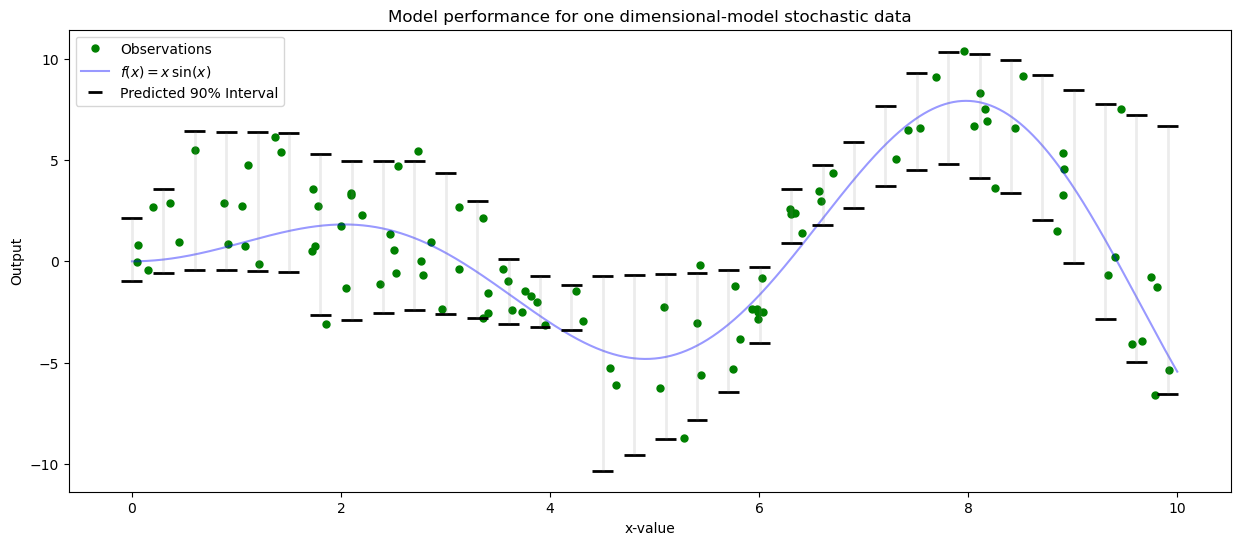

In [51]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

np.random.seed(100)

def f(x):
    return x * np.sin(x)

# Generate data
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)
y = f(X).ravel()
dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)
predicted_percentiles = learner.predict(xx)
y_lower_pred, y_pred, y_upper_pred = predicted_percentiles[:, 0], predicted_percentiles[:, 1], predicted_percentiles[:, 2]

# Calculate dynamic true percentiles for each point in xx
dy_xx = 1.5 + 1.0 * np.random.random(xx.shape[0])  # Ensure dy_xx matches the length of xx
y_lower_true = f(xx).ravel() - 1.645 * dy_xx  # 10th percentile
y_upper_true = f(xx).ravel() + 1.645 * dy_xx  # 90th percentile

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(X, y, 'g.',markersize=10, label='Observations')
plt.plot(xx, f(xx), 'blue', label=u'$f(x) = x\,\sin(x)$', alpha=0.4)


indexing = xx.ravel()

# Add vertical whiskers for predicted percentiles at regular intervals
interval = 30  # Interval for placing the vertical bars
for i in range(0, len(xx), interval):
    x_val = indexing[i]
    
    lower_val_pred = y_lower_pred[i]
    upper_val_pred = y_upper_pred[i]

    median_val_pred = y_pred[i]

    
    median_value = (y_upper_pred[i] + y_lower_pred[i]) / 2
    lower_error = y_pred[i] - y_lower_pred[i]
    upper_error = y_upper_pred[i] - y_pred[i]

    
    plt.hlines(upper_val_pred, x_val - 0.1, x_val + 0.1, color='black', linewidth=2)
    plt.hlines(lower_val_pred, x_val - 0.1, x_val + 0.1, color='black', linewidth=2)
    #plt.errorbar(x_val, median_value, yerr=[[(upper_error - lower_error]], fmt='c|', alpha=0.7)

    plt.errorbar(x_val, median_val_pred, yerr=[[lower_error], [upper_error]], fmt='grey', alpha=0.15, capthick=2, elinewidth=2)

#¤vertical_bar_true = Line2D([0], [0], linestyle='none', marker='|', color='grey', markersize=10, markeredgewidth=1.5)

# Automatically generate default legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
# Append the custom handler for the vertical bars

legend_prediction = Line2D([0], [0], linestyle='none', marker='_', color='black', markersize=10, markeredgewidth=2)
handles.append(legend_prediction)
labels.append('Predicted 90% Interval')

plt.title("Model performance for one dimensional-model stochastic data")
plt.xlabel("x-value")
plt.ylabel("Output")
plt.legend(handles=handles, labels=labels, loc="best")

plt.show()

In [16]:
print("CWC for one-dimensional model is is:")
calculate_cwc(f(xx), y_lower_pred, y_upper_pred)

CWC for one-dimensional model is is:


0.47556421160697937

## Extend the model to use two dimensions

In [17]:
## Build the Model

class q_model_multi_dimensional(nn.Module):
    def __init__(self, 
                 quantiles, 
                 in_shape=2,  
                 dropout=0.5):     
        super().__init__()
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = len(quantiles)
        self.dropout = dropout
        self.build_model()
        self.init_weights()
        
    def build_model(self): 
        self.base_model = nn.Sequential(
            nn.Linear(self.in_shape, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
            nn.Linear(64, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
        )
        final_layers = [
            nn.Linear(64, 1) for _ in range(len(self.quantiles))
        ]
        self.final_layers = nn.ModuleList(final_layers)
        
    def init_weights(self):
        for m in chain(self.base_model, self.final_layers):
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight)
                nn.init.constant_(m.bias, 0)        
        
    def forward(self, x):
        tmp_ = self.base_model(x)
        return torch.cat([layer(tmp_) for layer in self.final_layers], dim=1)


class QuantileLoss_2(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(quantiles):
            errors = target - preds[:, i]
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss


class Learner_2:
    def __init__(self, model, optimizer_class, loss_func, device='cpu'):
        self.model = model.to(device)
        self.optimizer = optimizer_class(self.model.parameters())
        self.loss_func = loss_func.to(device)
        self.device = device
        self.loss_history = []
        
    def fit(self, x, y, epochs, batch_size):
        self.model.train()
        for e in range(epochs):
            shuffle_idx = np.arange(x.shape[0])
            np.random.shuffle(shuffle_idx)
            x = x[shuffle_idx]
            y = y[shuffle_idx]
            epoch_losses = []
            for idx in range(0, x.shape[0], batch_size):
                self.optimizer.zero_grad()
                batch_x = torch.from_numpy(
                    x[idx : min(idx + batch_size, x.shape[0]),:]
                ).float().to(self.device).requires_grad_(False)
                batch_y = torch.from_numpy(
                    y[idx : min(idx + batch_size, y.shape[0])]
                ).float().to(self.device).requires_grad_(False)
                preds = self.model(batch_x)
                loss = loss_func(preds, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.cpu().detach().numpy())                                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if (e+1) % 500 == 0:
                print("Epoch {}: {}".format(e+1, epoch_loss))
                
    def predict(self, x, mc=False):
        if mc:
            self.model.train()
        else:
            self.model.eval()
        return self.model(torch.from_numpy(x).to(self.device).requires_grad_(False)).cpu().detach().numpy()

In [18]:
# Instantiate model for 2D data
quantiles = [.05, .5, .95]
model_2 = q_model_multi_dimensional(quantiles, in_shape=2, dropout=0.1)  # in_shape set to 2 for 2D input
loss_func_2 = QuantileLoss_2(quantiles)
learner_2 = Learner_2(model_2, partial(torch.optim.Adam, weight_decay=1e-6), loss_func_2)

# Define X and Y for two-dimensional input
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)
Y = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
Y = Y.astype(np.float32)

# Combine X and Y to create two-dimensional input data
X_2 = np.concatenate([X, Y], axis=1)

# Define the function for two-dimensional predictions
def g(x, y):
    """The function to predict in 2D."""
    return x * np.sin(x) + y * np.cos(y)

# Update observations for 2D
y_2 = g(X_2[:, 0], X_2[:, 1]).ravel()
dy = 1.5 + 1.0 * np.random.random(y_2.shape)  # Noise standard deviation
noise = np.random.normal(0, dy)
y_2 += noise
y_2 = y_2.astype(np.float32)

In [19]:
# Run training for 2D model
epochs = 5000
#learner_2.fit(X_2, y_2, epochs, batch_size=10)

In [20]:
model_2_name = "two_dimensional_input_model"
handle_model(model_2_name, model_2, X_2, y_2, learner_2, epochs)

# Save data for replicability
if OVERWRITE == True:
    print("Overwriting saved training data...")
    np.save("./saved_training_data/multi_dimensional_mocked_X.npy", X_2)
    np.save("./saved_training_data/multi_dimensional_mocked_y.npy", y_2)

Model exists, loading...
== Model loaded! == 
Overwriting saved training data...


Assign index to training data to get uncertainty evaluation plot for multi-dimensional data 

In [21]:
# generate some data to test upon
X_test = np.atleast_2d(np.random.uniform(0, 10.0, size=50)).T
X_test = X_test.astype(np.float32)
Y_test = np.atleast_2d(np.random.uniform(0, 10.0, size=50)).T
Y_test = Y_test.astype(np.float32)

test_data = np.concatenate([X_test, Y_test], axis=1)
print(len(test_data))

50


In [22]:
Y_test.shape

(50, 1)

In [23]:
test_data.shape

(50, 2)

In [24]:
# Make the prediction on the meshed x-axis
predicted_percentiles = learner_2.predict(test_data)

y_lower_pred, y_pred, y_upper_pred = predicted_percentiles[:, 0], predicted_percentiles[:, 1], predicted_percentiles[:, 2]

50
50


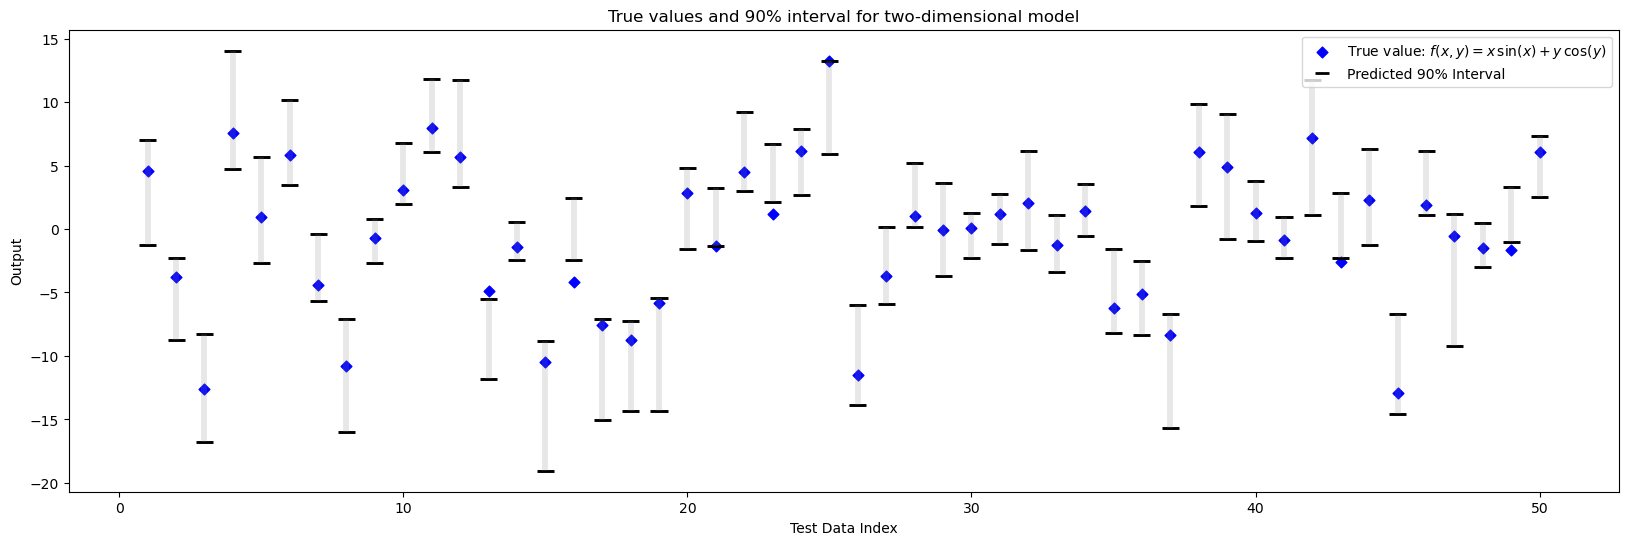

In [46]:
plt.figure(figsize=(20, 6))
test_data_indexed = list(range(1, len(test_data) + 1))

print(len(y_pred))
print(len(test_data_indexed))

plt.scatter(test_data_indexed, g(X_test, Y_test), color='blue', label=r'True value: $f(x, y) = x\,\sin(x) + y\,\cos(y)$', marker='D', s=30)
#plt.scatter(test_data_indexed, y_pred, color='black', label='Predicted median value', s=10)

interval = 1
for i in range(0, len(test_data), interval):
    median_value = (y_upper_pred[i] + y_lower_pred[i]) / 2
    lower_error = y_pred[i] - y_lower_pred[i]
    upper_error = y_upper_pred[i] - y_pred[i]

    plt.hlines(y_lower_pred[i], i + 1 - 0.3, i + 1 + 0.3, color='black', linewidth=2.1)
    plt.hlines(y_upper_pred[i], i + 1 - 0.3, i + 1 + 0.3, color='black', linewidth=2.1)
    plt.errorbar(i + 1, y_pred[i], yerr=[[lower_error], [upper_error]], fmt='grey', alpha=0.19, capthick=2, elinewidth=4.2)


handles, labels = plt.gca().get_legend_handles_labels()

legend_prediction = Line2D([0], [0], linestyle='none', marker='_', color='black', markersize=10, markeredgewidth=2)
handles.append(legend_prediction)
labels.append('Predicted 90% Interval')

plt.legend(handles=handles, labels=labels, loc="best")
plt.title("True values and 90% interval for two-dimensional model")
plt.xlabel("Test Data Index")
plt.ylabel("Output")

plt.show()

In [28]:
print("CWC for two-dimensional model is is:")
calculate_cwc(g(X_test, Y_test), y_lower_pred, y_upper_pred)

CWC for two-dimensional model is is:


0.2479889839887619

# Multi-dimensional model for real-data

## Real data for the model

To continue modeling with more realistic data I chose house prices for advanced regression dataset from Kaggle: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

As Kaggle data is made for competing, the test data does not actually contain the sale price value which we are trying to predict. Therefore we must use the training data both for training and testing the model so we'll split it into two (other ways to trainsplit can be considered in the future): 

In [29]:
train_df = pd.read_csv("data/train.csv")
train_df = train_df.drop('Id', axis=1)

In [30]:
display(train_df.head(3))
display(train_df.columns)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [31]:
SELECTED_ATTRIBUTES = ["YearBuilt", "MSSubClass", "LotArea", "YrSold", "OverallCond"]

In [32]:
def split_dataset(dataset, test_ratio=0.05, seed=None):
    if seed is not None:
        np.random.seed(seed)
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

selected_cols_test_df = train_df[[*SELECTED_ATTRIBUTES, "SalePrice"]].copy()
training_data_real_data, test_data_real_data = split_dataset(selected_cols_test_df, seed=100)

X_real = training_data_real_data[SELECTED_ATTRIBUTES]
y_real = training_data_real_data[["SalePrice"]]
display(X_real.describe())
display(X_real.shape)
display(y_real.shape)

# save data for replicability
if OVERWRITE == True:
    print("Overwriting saved training data...")
    X_real.to_csv("saved_training_data/real_training_data_X.csv")
    y_real.to_csv("saved_training_data/real_training_data_y.csv")

,YearBuilt,MSSubClass,LotArea,YrSold,OverallCond
count,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000
mean,1970.909026,56.733524,10540.946275,2007.813754,5.590258
std,30.355049,42.121644,10169.113231,1.328371,1.117995
min,1872.000000,20.000000,1300.000000,2006.000000,1.000000
25%,1953.000000,20.000000,7500.000000,2007.000000,5.000000
50%,1972.000000,50.000000,9468.500000,2008.000000,5.000000
75%,2000.000000,70.000000,11601.500000,2009.000000,6.000000
max,2010.000000,190.000000,215245.000000,2010.000000,9.000000


(1396, 5)

(1396, 1)

Overwriting saved training data...


In [33]:
numerical_cols = ["YearBuilt", "LotArea", "YrSold", "OverallCond"]
categorical_cols = ["MSSubClass"]
X_numerical = X_real[numerical_cols].to_numpy(dtype=np.float32)
y_real_np = y_real.to_numpy(dtype=np.float32)
X_categorical = X_real[categorical_cols]

In [34]:
from sklearn.preprocessing import StandardScaler

# Normalize the numerical values
scaler = StandardScaler()
scaler.fit(X_numerical)
X_numerical_scaled = scaler.transform(X_numerical)

# Save trained scaler for replicability
scaler_filename = "saved_training_data/scaler.save"
joblib.dump(scaler, scaler_filename)

['saved_training_data/scaler.save']

In [35]:
# Handle the one categorical value
categories = sorted(X_categorical["MSSubClass"].unique())
category_to_index = {category: i for i, category in enumerate(categories)}
indices = X_categorical["MSSubClass"].map(category_to_index).to_numpy()
X_categorical_one_hot = F.one_hot(torch.tensor(indices), num_classes=len(categories)).numpy()

# Combine scaled numerical and one-hot encoded categorical data
X_combined_preprocessed = np.hstack((X_numerical_scaled, X_categorical_one_hot))

In [36]:
quantiles = [.05, .5, .95]
INPUT_DIMENSIONS = 19 # These account for the one hot encoding as well
model_real_data = q_model_multi_dimensional(quantiles, in_shape=INPUT_DIMENSIONS, dropout=0.1)
learner_real_data = Learner_2(model_real_data, partial(torch.optim.Adam, weight_decay=1e-6), loss_func_2)

In [37]:
real_data_model_name = "multi_dimensional_real_input_model"
epochs = 5000
handle_model(real_data_model_name, model_real_data, X_combined_preprocessed, y_real_np, learner_real_data, epochs, overwrite_model=False)

Model exists, loading...
== Model loaded! == 


In [38]:
# NEW

X_real_test = test_data_real_data 

y_real_test = test_data_real_data[["SalePrice"]]
y_real_np_test = y_real_test.to_numpy(dtype=np.float32)

# Separate numerical and categorical data from test dataset
X_real_numerical_test = X_real_test[numerical_cols].to_numpy(dtype=np.float32)
X_real_categorical_test = X_real_test[categorical_cols]

# Scale numerical features using the scaler fitted on the training data
X_real_numerical_test_scaled = scaler.transform(X_real_numerical_test)

# One-hot encode categorical features (ensure using the same category mapping as for training)
indices_test = X_real_categorical_test["MSSubClass"].map(category_to_index).to_numpy()
X_real_categorical_test_one_hot = F.one_hot(torch.tensor(indices_test), num_classes=len(category_to_index)).numpy()

# Combine scaled numerical data and one-hot encoded categorical data
X_real_test_combined = np.hstack((X_real_numerical_test_scaled, X_real_categorical_test_one_hot)).astype(np.float32)

# Make predictions using the processed test data
predicted_percentiles_real_data = learner_real_data.predict(X_real_test_combined)

# Extract percentiles from predictions
real_lower_pred_test, real_pred_test, real_upper_pred_test = predicted_percentiles_real_data[:, 0], predicted_percentiles_real_data[:, 1], predicted_percentiles_real_data[:, 2]


Extend the new data to new dimension

Text(0, 0.5, 'House Price')

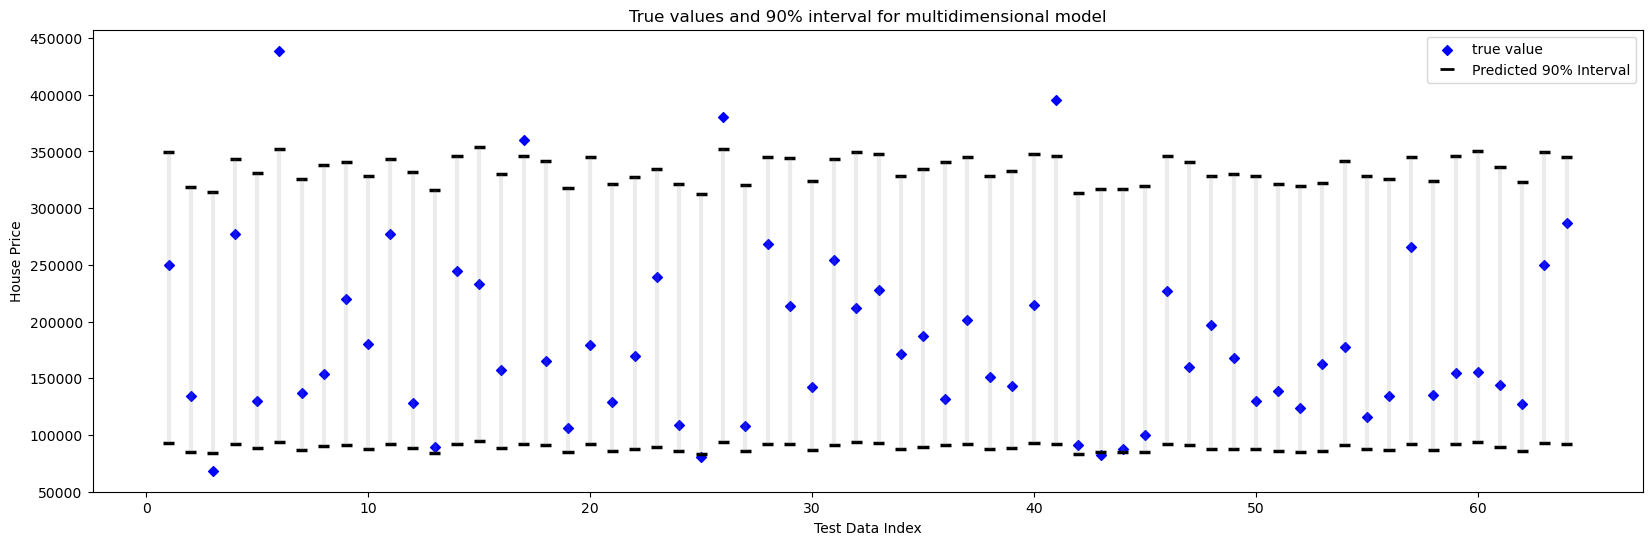

In [48]:

from matplotlib.lines import Line2D

# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 6))

test_data_indexed_real_test = list(range(1, len(y_real_np_test) + 1))
index_mapper = y_real_np_test.ravel()

#plt.scatter(test_data_indexed_real_test, real_pred_test, color='black', label='predicted median value', s=10)
plt.scatter(test_data_indexed_real_test, y_real_np_test, color='blue', label='true value', marker='D', s = 25)


# Add vertical bars for true percentiles at regular intervals
interval = 1  # Interval for placing the vertical bars
for i in range(0, len(y_real_np_test), interval):
    x_val_test = index_mapper[i]
    
    lower_pred_r_test = real_lower_pred_test[i]
    upper_pred_r_test = real_upper_pred_test[i]
    median_pred_r_test = real_pred_test[i]
    y_value_test = median_pred_r_test
    lower_error_test = y_value_test - lower_pred_r_test
    upper_error_test = upper_pred_r_test - y_value_test

    # Plot the main data point
    #ax.plot(i + 1, y_value_test, 'yo', alpha=0.9)
    
    # Plot the whiskers for the error bars
    ax.hlines(y_value_test - lower_error_test, i + 1 - 0.25, i + 1 + 0.25, color='black', linewidth=2.5)
    ax.hlines(y_value_test + upper_error_test, i + 1 - 0.25, i + 1 + 0.25, color='black', linewidth=2.5)
    plt.errorbar(i + 1, y_value_test, yerr=[[lower_error_test], [upper_error_test]], fmt='grey', alpha=0.15, capthick=2, elinewidth=3)


# Automatically generate default legend handles and labels
handles, labels = ax.get_legend_handles_labels()

legend_prediction = Line2D([0], [0], linestyle='none', marker='_', color='black', markersize=10, markeredgewidth=2)
handles.append(legend_prediction)
labels.append('Predicted 90% Interval')

ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("True values and 90% interval for multidimensional model")
ax.set_xlabel("Test Data Index")
ax.set_ylabel("House Price")

In [40]:
print("CWC is:")
calculate_cwc(y_real_np_test, real_lower_pred_test, real_upper_pred_test)

CWC is:


0.661204993724823